# COURSE: A deep understanding of deep learning
## CODE CHALLENGE

In [159]:
# import libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,TensorDataset

In [160]:
# import dataset (comes with seaborn)
import seaborn as sns
iris = sns.load_dataset('iris')
iris

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


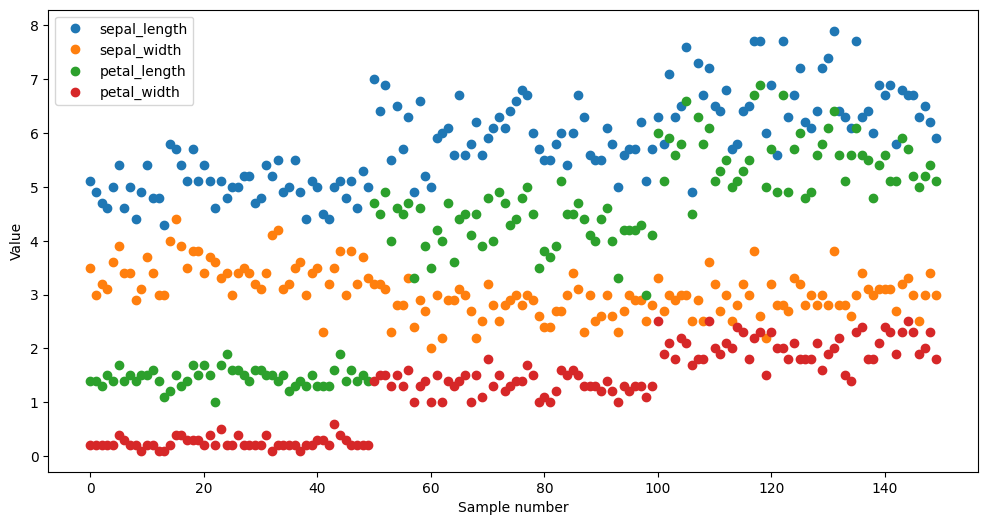

In [161]:
# plot the data
iris.plot(marker='o',linestyle='none',figsize=(12,6))
plt.xlabel('Sample number')
plt.ylabel('Value')
plt.show()

In [162]:
####   ------------------------------- < NOTE ABOUT THIS CELL!!! > ---------------------------------------   ####
#                                                                                                               #
# The code here is intentionally commented out. We're going to use this in the lecture "The importance of       #
# data standardization" in the next section. If you're not doing that lecture, leave this commented! Thanks!    #
#                                                                                                               #
####   ------------------------------- </ NOTE ABOUT THIS CELL!!! > --------------------------------------   ####


# # z-score the data
# import scipy.stats as stats
# cols2zscore = iris.keys()
# cols2zscore = cols2zscore.drop('species')
# iris[cols2zscore] = iris[cols2zscore].apply(stats.zscore)

# iris.plot(marker='o',linestyle='none',figsize=(12,6))
# plt.xlabel('Sample number')
# plt.ylabel('Value')
# plt.show()

In [163]:
# organize the data

# convert from pandas dataframe to tensor
data = torch.tensor( iris[iris.columns[0:4]].values ).float()

# transform species to number
labels = torch.zeros(len(data), dtype=torch.long)
# labels[iris.species=='setosa']   = 0 # don't need!
labels[iris.species=='versicolor'] = 1
labels[iris.species=='virginica']  = 2

# Break the data into batches

In [164]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(data, labels, test_size=.2)


# then convert them into PyTorch Datasets (note: already converted to tensors)
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)


# finally, translate into dataloader objects
batchsize    = 8
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data) # how big should these batches be??

In [165]:
# check sizes of data batches
for X,y in train_loader:
  print(X.shape,y.shape)

# go back and set drop_last=True in training DataLoader

torch.Size([8, 4]) torch.Size([8])
torch.Size([8, 4]) torch.Size([8])
torch.Size([8, 4]) torch.Size([8])
torch.Size([8, 4]) torch.Size([8])
torch.Size([8, 4]) torch.Size([8])
torch.Size([8, 4]) torch.Size([8])
torch.Size([8, 4]) torch.Size([8])
torch.Size([8, 4]) torch.Size([8])
torch.Size([8, 4]) torch.Size([8])
torch.Size([8, 4]) torch.Size([8])
torch.Size([8, 4]) torch.Size([8])
torch.Size([8, 4]) torch.Size([8])
torch.Size([8, 4]) torch.Size([8])
torch.Size([8, 4]) torch.Size([8])
torch.Size([8, 4]) torch.Size([8])


# Construct the model and training plans

In [166]:
# a function that creates the ANN model


def createANewModel():
    # model architecture
    ANNiris = nn.Sequential(
        nn.Linear(4, 64),  # input layer
        nn.ReLU(),  # activation unit
        nn.Linear(64, 64),  # hidden layer
        nn.ReLU(),  # activation unit
        nn.Linear(64, 3),  # output units
    )

    # loss function
    lossfun = nn.CrossEntropyLoss()

    # optimizer
    optimizer = torch.optim.SGD(ANNiris.parameters(), lr=0.001)

    return ANNiris, lossfun, optimizer

In [167]:
# train the model

# global parameter
numepochs = 500


def trainTheModel():
    # initialize accuracies as empties
    trainAcc = []
    testAcc = []
    losses = []

    # loop over epochs
    for epochi in range(numepochs):
        
        ANNiris.train()  # put ANN into training mode
        
        # loop over training data batches
        batchAcc = []
        batchLoss = []
        for X, y in train_loader:
            # forward pass and loss
            yHat = ANNiris(X)
            loss = lossfun(yHat, y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # compute training accuracy just for this batch
            batchAcc.append(
                100 * torch.mean((torch.argmax(yHat, axis=1) == y).float()).item()
            ) 
            batchLoss.append(loss.item()) # append the loss for this batch
        # end of batch loop...

        # now that we've trained through the batches, get their average training accuracy
        trainAcc.append(np.mean(batchAcc))
        losses.append(np.mean(batchLoss))

    # test accuracy
    X, y = next(iter(test_loader))  # extract X,y from test dataloader
    ANNiris.eval()  # put ANN into testing mode
    with torch.no_grad():
        predlabels = torch.argmax(ANNiris(X), axis=1)
        
    testAcc.append(100 * torch.mean((predlabels == y).float()).item())

    # function output
    return trainAcc, testAcc, losses

### Test it out for mini-batch sizes of 1, 2, 4, 8, 16, 32, 64, 128, 256, 512 (2**n)

In [168]:
# global parameter
numepochs = 500

batchsizes = (2 ** np.arange(0, 7)).astype(int)

print(batchsizes)

# initialize accuracies as empties
trainAcc = []
testAcc = []
losses = []


# loop over batch sizes
for batchi in batchsizes:
    print(f'batch size: {batchi}')
    
    # create a new model
    ANNiris, lossfun, optimizer = createANewModel()

    # create new dataloaders
    train_loader = DataLoader(
        train_data, batch_size=int(batchi), shuffle=True, drop_last=True
    )
    test_loader = DataLoader(
        test_data, batch_size=test_data.tensors[0].shape[0]
    )  # how big should these batches be??

    # train the model
    trainAcci, testAcci, lossesi = trainTheModel()

    # append accuracies
    trainAcc.append(trainAcci)
    testAcc.append(testAcci)
    losses.append(lossesi)
        

[ 1  2  4  8 16 32 64]
batch size: 1
batch size: 2
batch size: 4
batch size: 8
batch size: 16
batch size: 32
batch size: 64


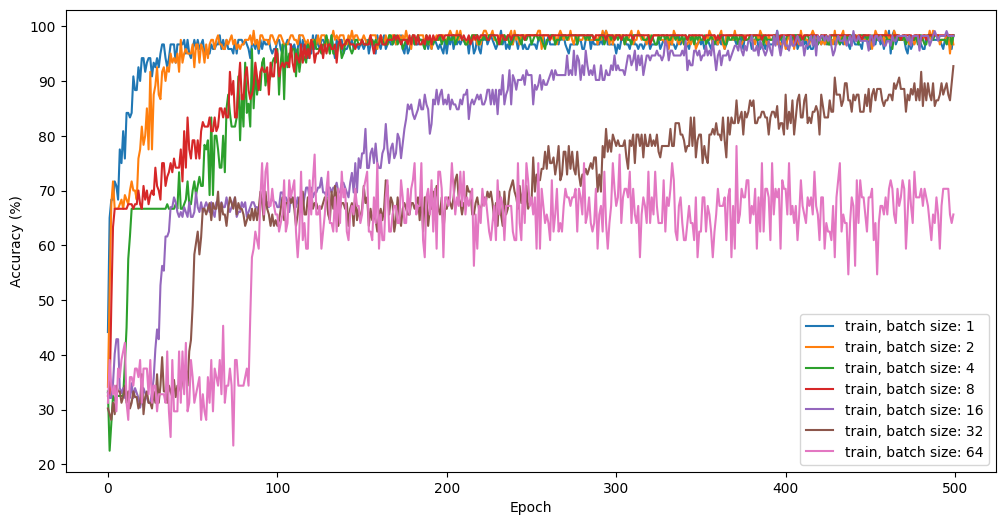

In [169]:
# Plot the accuracies over epochs for each batch size as the parameter
plt.figure(figsize=(12, 6))

for i, batchi in enumerate(batchsizes):
    plt.plot(trainAcc[i], label=f'train, batch size: {batchi}')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()


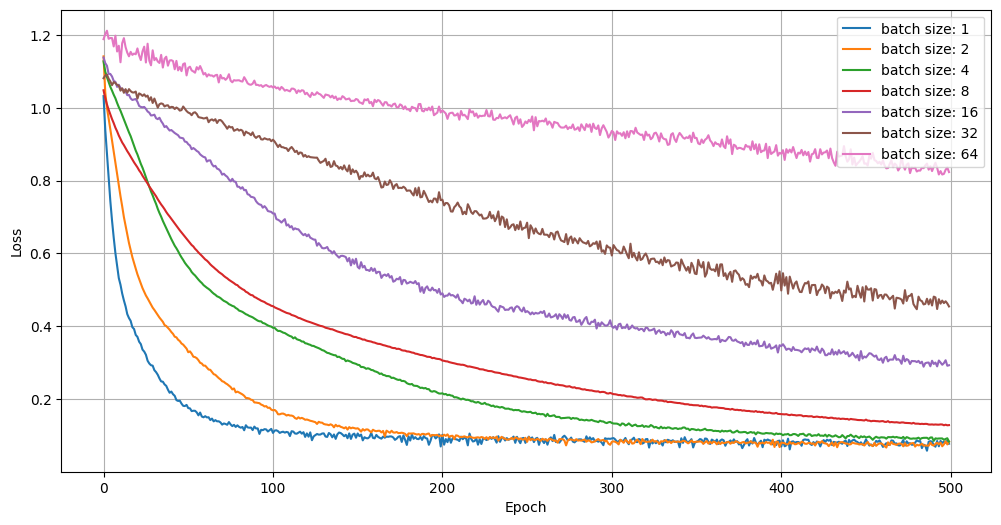

In [172]:
# Plot the losses over epochs for each batch size as the parameter
plt.figure(figsize=(12, 6))

for i, batchi in enumerate(batchsizes):
    plt.plot(losses[i], label=f'batch size: {batchi}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Additional explorations

In [171]:
# 1) Is there a relationship between the test_size parameter in train_test_split(), the batchsize parameter in DataLoader,
#    and the length of test_data? Think of your answer first, then test it in code, by creating new dataloader objects 
#    with varying test_size parameters.
#    Hint: You can use the code 'len(test_data.dataset.tensors[1])', which returns the length of the labels vector.
# 
# 2) Let's say you didn't care about the three types of irises; you only want a model that labels a flower as setosa or 
#    "other." What would you have to change in the data and in the model to make this work?
# 
# 3) In the course section "More on data," you will learn that unbalanced designs can be problematic for DL models (an
#    unbalanced design means that there is an uneven distribution of samples in different categories). Does the 
#    modification in #2 produce an unbalanced design? To find out, count the number of data labels that are 0 (setosa) or
#    1 (not setosa).
# 